In [134]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.use('pdf')
fpath = Path(mpl.get_data_path(), "fonts/ttf/cmu_serif_roman.ttf")
fprop = fm.FontProperties(fname=fpath)

width = 6.2 #inches
height = width/1.614

font = {'family':'serif', 'serif': ['cmr10']}
plt.rc('font',**font)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('axes', titlesize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

media = [
    'ARD_Monitor',
    'ARD_Hart aber fair',
    'ARD_Maischberger', 
    'ARD_Tagesthemen',
    'ARD_Anne Will',
    'ARD_youtube',
    'ZDF_maybrit illner', 
    'ZDF_Markus Lanz', 
    'ZDF_Frontal 21', 
    'ZDF_frontal', 
    'ZDF_youtube',
    'ZDFh_youtube',
    'rest'
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [135]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(input_string.split()):
            upper_bound = len(input_string.split())
        output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [136]:
skip_computation = True

zdf_df = pd.read_pickle('../data/youtube_data.pkl')
zdf_df = zdf_df[zdf_df['medium'] == 'ZDF']
zdf_df['medium'] = 'ZDF_youtube'

zdfh_df = pd.read_pickle('../data/youtube_data.pkl')
zdfh_df = zdfh_df[zdfh_df['medium'] == 'ZDFheute Nachrichten']
zdfh_df['medium'] = 'ZDFh_youtube'

ard_df = pd.read_pickle('../data/youtube_data.pkl')
ard_df = ard_df[ard_df['medium'] == 'ARD']
ard_df['medium'] = 'ARD_youtube'

#rest_df = pd.read_pickle('../data/topics_combined.pkl')
rest_df = pd.read_pickle('../data/youtube_data.pkl')
rest_df = rest_df[rest_df['medium'] != 'ARD']
rest_df = rest_df[rest_df['medium'] != 'ZDF']
rest_df = rest_df[rest_df['medium'] != 'ZDFheute Nachrichten']
rest_df['medium'] = 'rest'

df = pd.read_pickle('../data/mediathek_data.pkl')
df['medium'] = df['medium']+'_'+df['id']
df = pd.concat([df, zdf_df])
df = pd.concat([df, zdfh_df])
df = pd.concat([df, ard_df])
df = pd.concat([df, rest_df])
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)



tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [137]:
if skip_computation:
    pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df = pd.read_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df = pd.read_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')
else:
    pos_counts_dict = {}
    neu_counts_dict = {}
    neg_counts_dict = {}
    for party in search_terms.keys():
        pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

    pos_counts_df = pd.DataFrame(pos_counts_dict)
    pos_counts_df = pos_counts_df.loc[media]
    pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neu_counts_df = pd.DataFrame(neu_counts_dict)
    neu_counts_df = neu_counts_df.loc[media]
    neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neg_counts_df = pd.DataFrame(neg_counts_dict)
    neg_counts_df = neg_counts_df.loc[media]
    neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

    pos_counts_df.to_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df.to_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df.to_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')

In [138]:
'''pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')

pos_counts_zdfheute = pd.read_pickle('../data/sentiment/pos_counts_df.pkl').loc[['ZDFheute Nachrichten']].rename({'ZDFheute Nachrichten':'ZDFh_youtube'})
pos_counts_df = pd.concat([pos_counts_df, pos_counts_zdfheute])

pos_counts_yt = pd.read_pickle('../data/sentiment/pos_counts_df.pkl')
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ARD']
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDF']
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDFheute Nachrichten']
pos_counts_yt = pd.DataFrame({'rest': pos_counts_yt.sum(axis=0)}).transpose()
pos_counts_df = pd.concat([pos_counts_df, pos_counts_yt])'''

"pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')\n\npos_counts_zdfheute = pd.read_pickle('../data/sentiment/pos_counts_df.pkl').loc[['ZDFheute Nachrichten']].rename({'ZDFheute Nachrichten':'ZDFh_youtube'})\npos_counts_df = pd.concat([pos_counts_df, pos_counts_zdfheute])\n\npos_counts_yt = pd.read_pickle('../data/sentiment/pos_counts_df.pkl')\npos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ARD']\npos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDF']\npos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDFheute Nachrichten']\npos_counts_yt = pd.DataFrame({'rest': pos_counts_yt.sum(axis=0)}).transpose()\npos_counts_df = pd.concat([pos_counts_df, pos_counts_yt])"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Text(0.5, 51.0, 'party'),
 Text(59.09374999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium and party, standardized')]

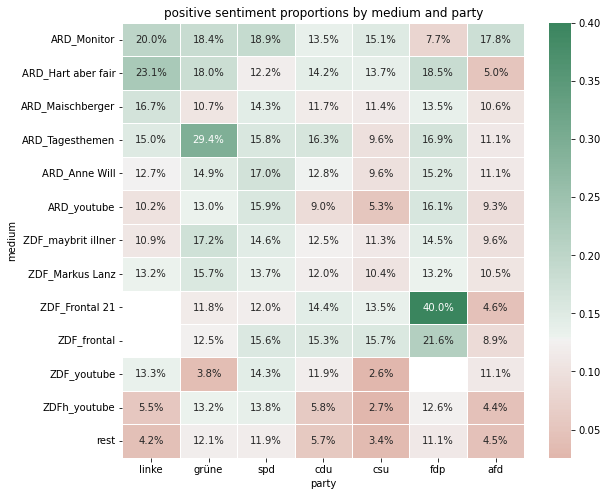

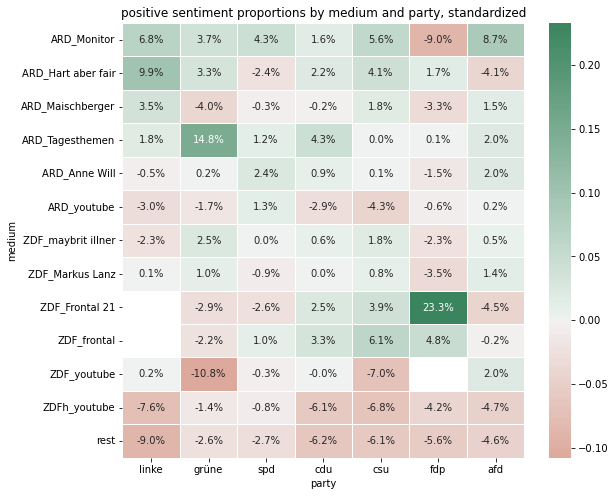

In [139]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        pos.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')

In [140]:
# POSITIVE SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &           AfD\\
# Mean &        10,8\,\% &      13,9\,\% &      14,8\,\% &  11,1\,\% &  9,7\,\% &   14,1\,\% &     10,1\,\% \\

In [141]:
print(f"positive sentiment means:\n{pos.mean()}\n\npositive sentiment standard deviation:\n{pos.std()}")

positive sentiment means:
linke    0.131601
grüne    0.146594
spd      0.145944
cdu      0.119486
csu      0.095537
fdp      0.167217
afd      0.091264
dtype: float64

positive sentiment standard deviation:
linke    0.056031
grüne    0.058258
spd      0.020368
cdu      0.032881
csu      0.046497
fdp      0.081451
afd      0.037815
dtype: float64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Text(0.5, 51.0, 'party'),
 Text(59.09374999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium and party, standardized')]

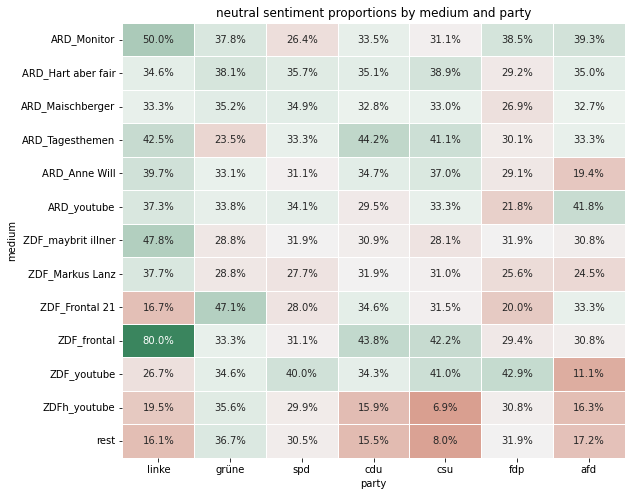

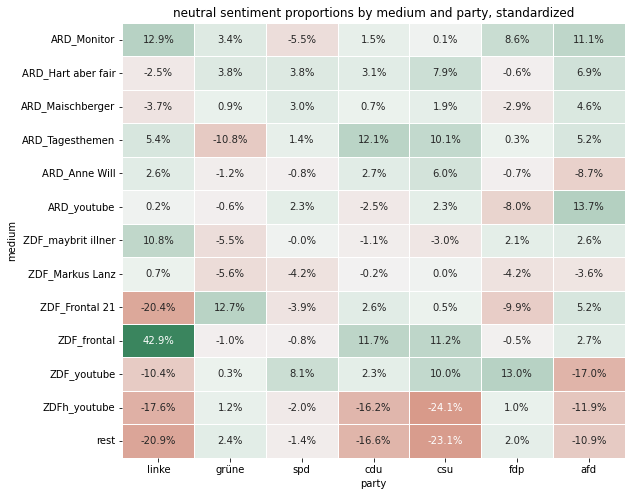

In [148]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neu.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')

In [143]:
# NEUTRAL SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &            AfD\\
# Mean &        48,9\,\% &      44,6\,\% &      36,3\,\% &  46,7\,\% &  49,5\,\% &  38,8\,\% &   41,8\,\% \\

In [144]:
print(f"neutral sentiment means:\n{neu.mean()}\n\nneutral sentiment standard deviation:\n{neu.std()}")

neutral sentiment means:
linke    0.370739
grüne    0.343380
spd      0.318958
cdu      0.320537
csu      0.310060
fdp      0.298638
afd      0.281212
dtype: float64

neutral sentiment standard deviation:
linke    0.169658
grüne    0.056035
spd      0.037241
cdu      0.084640
csu      0.113812
fdp      0.060665
afd      0.095126
dtype: float64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Text(0.5, 51.0, 'party'),
 Text(59.09374999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium and party, standardized')]

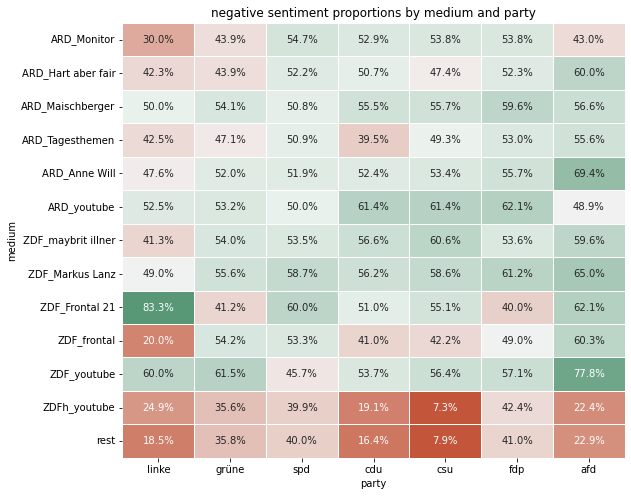

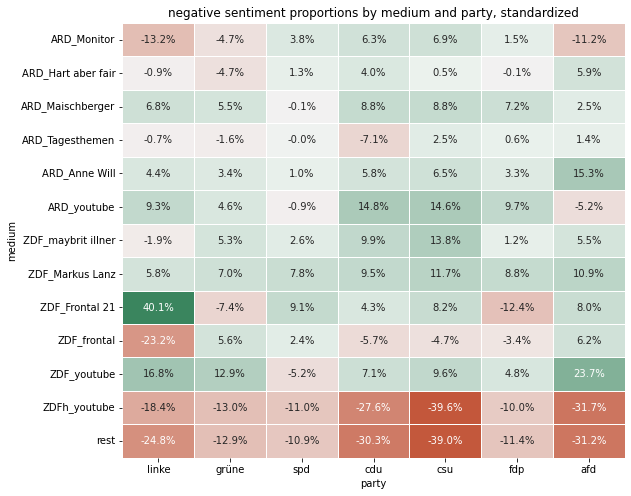

In [149]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neg.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')

In [146]:
# NEGATIVE SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &        AfD
# Mittelwert &  40,3\,\% &      41,4\,\% &      48,8\,\% &  42,2\,\% &  41,2\,\% &  47,1\,\% &   48,6\,\% \\

In [147]:
print(f"negative sentiment means:\n{neg.mean()}\n\nnegative sentiment standard deviation:\n{neg.std()}")

negative sentiment means:
linke    0.432273
grüne    0.486119
spd      0.508868
cdu      0.466374
csu      0.468397
fdp      0.523781
afd      0.541177
dtype: float64

negative sentiment standard deviation:
linke    0.176676
grüne    0.080369
spd      0.060617
cdu      0.141505
csu      0.182130
fdp      0.073821
afd      0.163852
dtype: float64
